In [1]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import joblib
from xgboost import plot_importance
import shap
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\HARUN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6])

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.groupby(['store', 'item'])['date'].count()


store  item
1      1       1826
       2       1826
       3       1826
       4       1826
       5       1826
               ... 
10     46      1826
       47      1826
       48      1826
       49      1826
       50      1826
Name: date, Length: 500, dtype: int64

<Axes: >

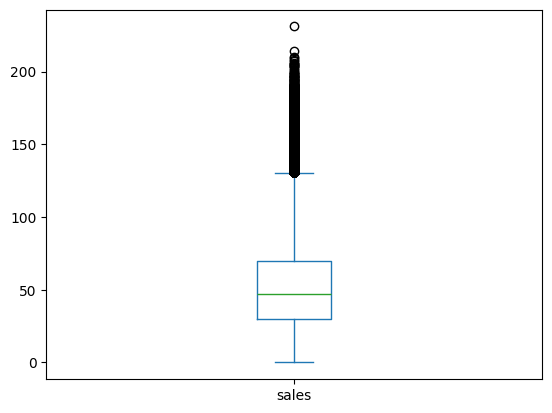

In [10]:
df['sales'].describe()
df['sales'].plot(kind='box')

In [11]:
df['sales'] = df['sales'].astype('int16')

# **EDA**

In [12]:
df.describe()

,date,store,item,sales,year,month,dayofweek
count,913000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287,2015.000548,6.523549,3.001643
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000,2013.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000,2014.000000,4.000000,1.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000,2015.000000,7.000000,3.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000,2016.000000,10.000000,5.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000,2017.000000,12.000000,6.000000
std,NaN,2.872283,14.430878,28.801144,1.414021,3.448535,1.999316


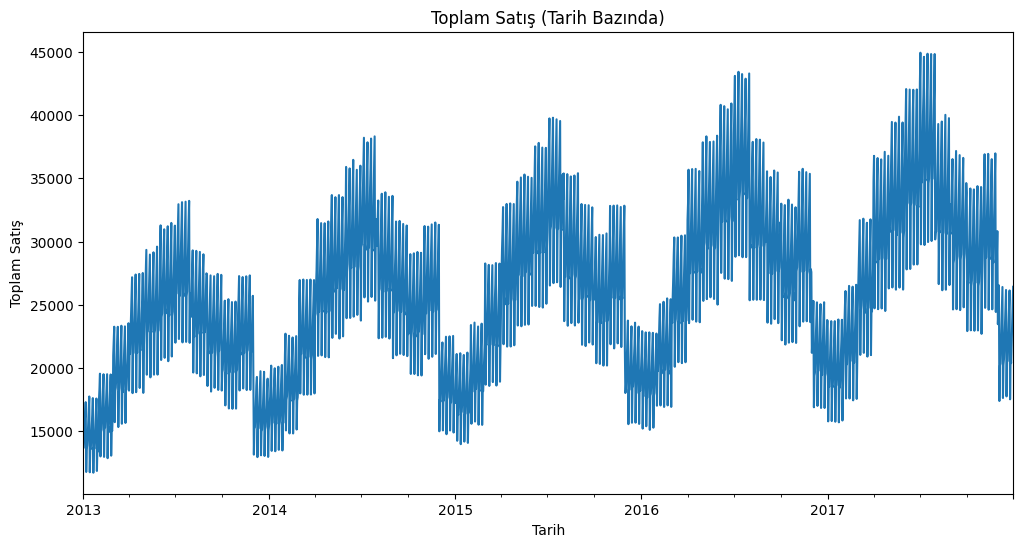

In [13]:
# Zaman serisi grafiği (tüm ürünler ve mağazalar için)
df.groupby('date')['sales'].sum().plot(kind='line', figsize=(12,6))
plt.title('Toplam Satış (Tarih Bazında)')
plt.xlabel('Tarih')
plt.ylabel('Toplam Satış')
plt.show()


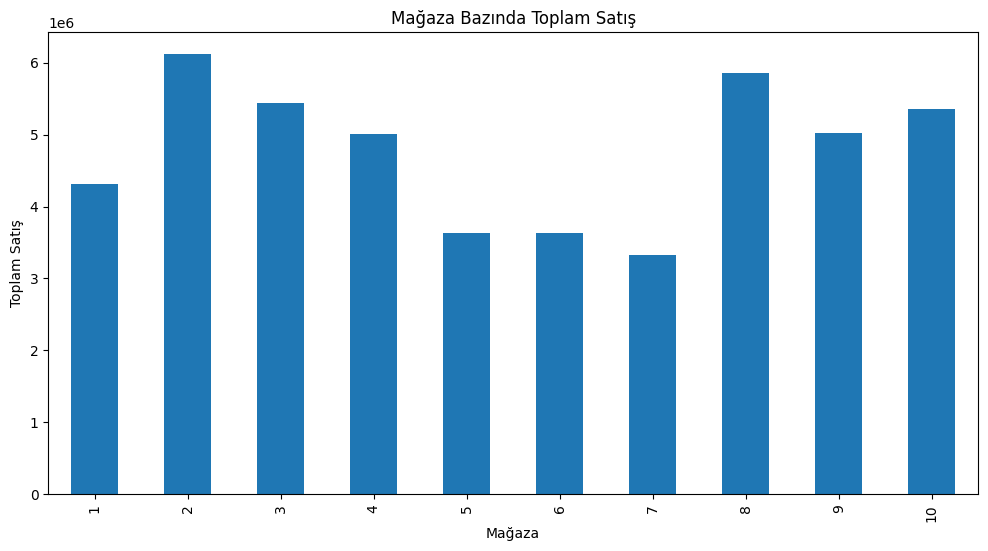

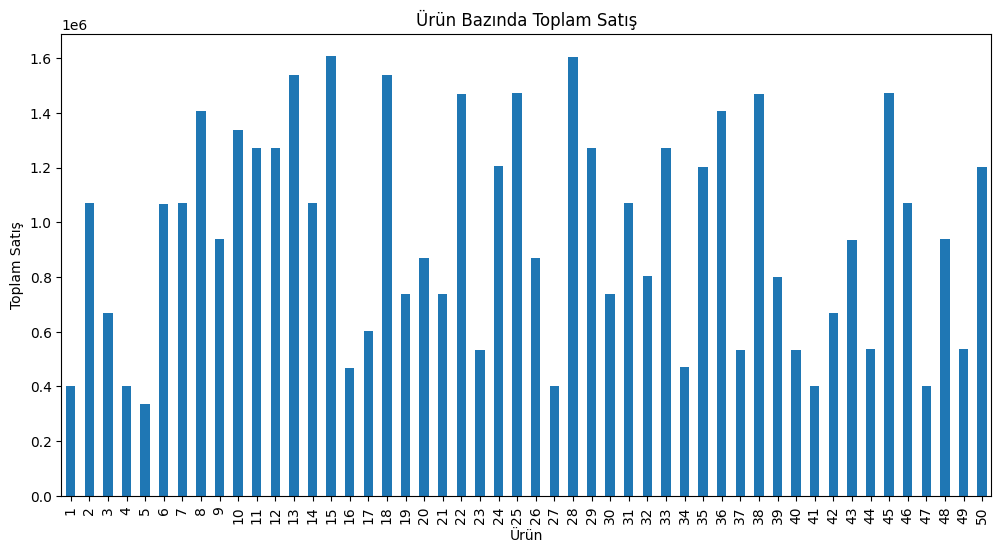

In [14]:
# Mağaza bazında satışların toplamı
df.groupby('store')['sales'].sum().plot(kind='bar', figsize=(12,6))
plt.title('Mağaza Bazında Toplam Satış')
plt.xlabel('Mağaza')
plt.ylabel('Toplam Satış')
plt.show()

# Ürün bazında satışların toplamı
df.groupby('item')['sales'].sum().plot(kind='bar', figsize=(12,6))
plt.title('Ürün Bazında Toplam Satış')
plt.xlabel('Ürün')
plt.ylabel('Toplam Satış')
plt.show()


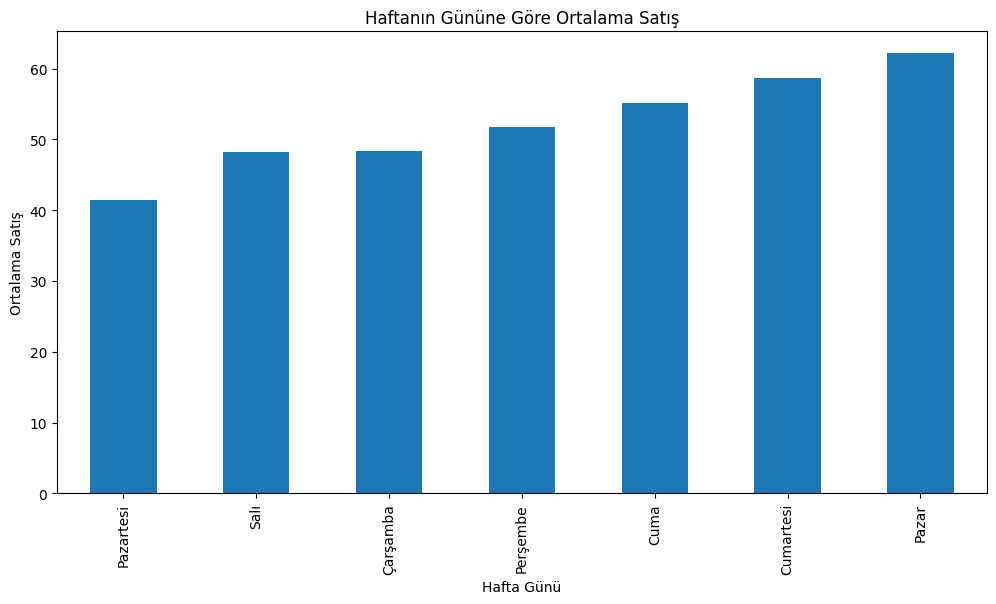

In [15]:
# Haftanın gününe göre satış ortalaması
df.groupby('dayofweek')['sales'].mean().plot(kind='bar', figsize=(12,6))
plt.title('Haftanın Gününe Göre Ortalama Satış')
plt.xlabel('Hafta Günü')
plt.ylabel('Ortalama Satış')
plt.xticks(range(7), ['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar'])
plt.show()


# Feature Engineering

In [16]:
df['lag_1'] = df.groupby(['store', 'item'])['sales'].shift(1)
df['lag_7'] = df.groupby(['store', 'item'])['sales'].shift(7)
df['lag_30'] = df.groupby(['store', 'item'])['sales'].shift(30)

In [17]:
df['rolling_mean_7'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).std()

In [18]:
df['sales_diff'] = df.groupby(['store', 'item'])['sales'].diff()

In [19]:
result = adfuller(df[df['store']==1][df['item']==1]['sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -3.157670556332822
p-value: 0.022569380626570396


C:\Users\HARUN\AppData\Local\Temp\ipykernel_9512\486095633.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = adfuller(df[df['store']==1][df['item']==1]['sales'])


In [20]:
df[['sales', 'lag_1', 'rolling_mean_7']].corr()

,sales,lag_1,rolling_mean_7
sales,1.000000,0.878715,0.925682
lag_1,0.878715,1.000000,0.936554
rolling_mean_7,0.925682,0.936554,1.000000


In [21]:
df_model = df.dropna()

# Machine Learning

In [22]:
X = df_model.drop(columns=['sales', 'date', 'lag_1', 'rolling_mean_7'])
y = df_model['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Model
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# Tahmin ve metrikler
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost MAE: 5.03
XGBoost RMSE: 6.54


In [23]:
# XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Parametre dağılımları
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10)
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # toplam denenecek parametre kombinasyonu
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# En iyi sonuçlar
print("En iyi parametreler:", random_search.best_params_)
print("En iyi MAE (negatif):", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
En iyi parametreler: {'colsample_bytree': np.float64(0.816642336315498), 'learning_rate': np.float64(0.15660624602633919), 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 372, 'subsample': np.float64(0.7864249579197649)}
En iyi MAE (negatif): -4.23142687479655


In [24]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Optimize XGBoost MAE: {mae:.2f}")
print(f"Optimize XGBoost RMSE: {rmse:.2f}")


Optimize XGBoost MAE: 4.19
Optimize XGBoost RMSE: 5.46


In [25]:
X.columns.tolist()

['store',
 'item',
 'year',
 'month',
 'dayofweek',
 'is_weekend',
 'lag_7',
 'lag_30',
 'rolling_std_7',
 'sales_diff']

In [31]:
# Eğitilmiş modelin kaydedilmesi
joblib.dump(best_model, 'xgboost_model.pkl')


['xgboost_model.pkl']

# Feature Importance (Özellik Önem Dereceleri)

In [32]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
pip install torch --upgrade

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/212.5 MB ? eta -:--:--
   ---------------------------------------- 1.3/212.5 MB 5.2 MB/s eta 0:00:41
   ---------------------------------------- 2.1/212.5 MB 4.7 MB/s eta 0:00:45
    --------------------------------------- 3.1/212.5 MB 5.0 MB/s eta 0:00:42
   - -------------------------------------- 5.8/212.5 MB 6.6 MB/s eta 0:00:32
   - -------------------------------------- 7.9/212.5 MB 7.3 MB/s eta 0:00:29
   - -------------------------------------- 10.0/212.5 MB 7.8 MB/s eta 0:00:27
   -- ------------------------------------- 12.1/212.5 MB 8.0 MB/s eta 0:00:25
   -- ------------------------------------- 14.2/212.5 MB 8.3 MB/s eta 0:00:24
   --- ------------------------------------ 16.3/212.5 MB 8.6 MB/s eta 0:00:23
   --- ------------------------------------ 18.6/212.5 MB 8.8 MB/s eta 0:00:23
   --- ------------------------------------ 20.7/212.5 MB 9.0 MB/s eta 0:


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 1000x600 with 0 Axes>

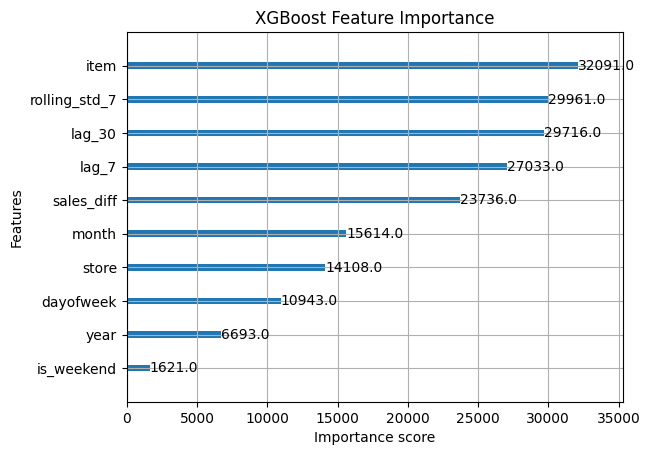

In [34]:
# Özellik önem grafiği
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10)  # İlk 10 özelliği göster
plt.title("XGBoost Feature Importance")
plt.show()


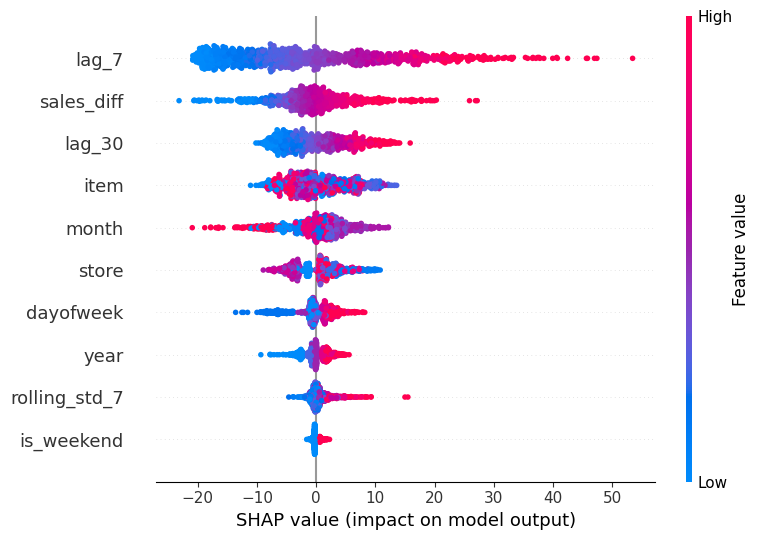

In [35]:
# SHAP için ağaç tabanlı explainer'ı kullan
explainer = shap.TreeExplainer(best_model)

# X_test'ten örnek al (örneğin 1000 satır)
X_sample = X_test.sample(n=1000, random_state=42)

# SHAP değerlerini hesapla
shap_values = explainer.shap_values(X_sample)

# SHAP özet grafiğini çiz
shap.summary_plot(shap_values, X_sample)
